In [47]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [48]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [50]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [51]:
# reflect an existing database into a new model
from sqlalchemy import create_engine, MetaData

# Create an engine to connect to the existing database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Create a metadata object
metadata = MetaData()

# Reflect the database tables into the metadata
metadata.reflect(bind=engine)

# Create a new base using the reflected tables
Base = automap_base(metadata=metadata)
Base.prepare()

# If you have specific tables in your database, you can access them like this:
Measurement = Base.classes.measurement
Station = Base.classes.station


# reflect the tables


In [52]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [53]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [54]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [55]:
# Find the most recent date in the data set.

# Find the most recent date
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print("The most recent date in the data set is:", most_recent_date[0])



The most recent date in the data set is: 2017-08-23


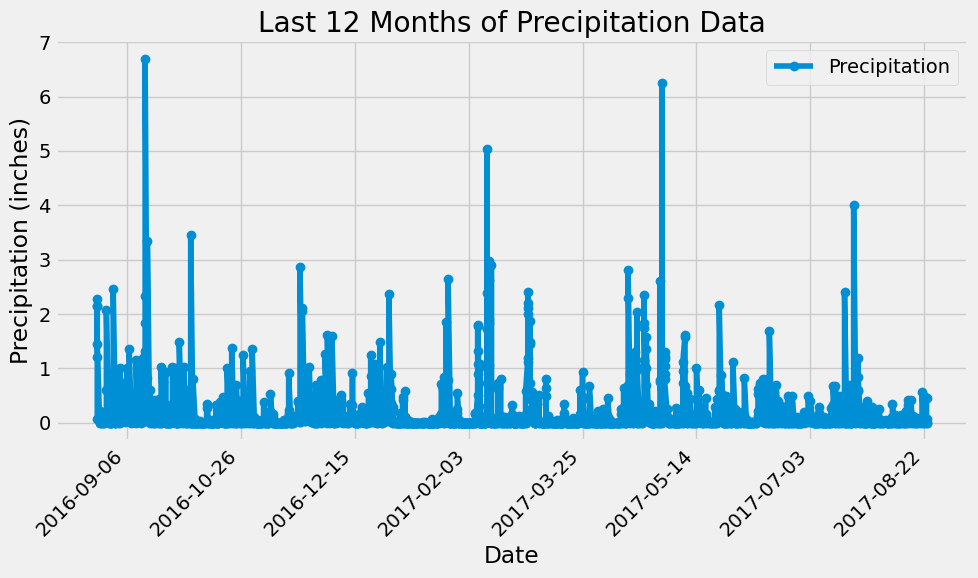

In [56]:
# Retrieve the most recent date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Drop rows with missing precipitation data
df = df.dropna()

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data as a line plot
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], label='Precipitation', marker='o')
plt.title('Last 12 Months of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both'))  # Reduce clutter
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
# Use Pandas to calculate the summary statistics for the precipitation data

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()

print(summary_statistics)


count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(func.distinct(Station.station))).scalar()

print("Total number of stations: ", total_stations)


Total number of stations:  9


In [59]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to find the most active stations and their counts
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station ID: {station}, Count: {count}")



Most Active Stations:
Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [60]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# find the most active station
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

# Extract the most active station ID
most_active_station_id = most_active_station[0]

#calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()

# Print the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")


Most Active Station ID: USC00519281
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


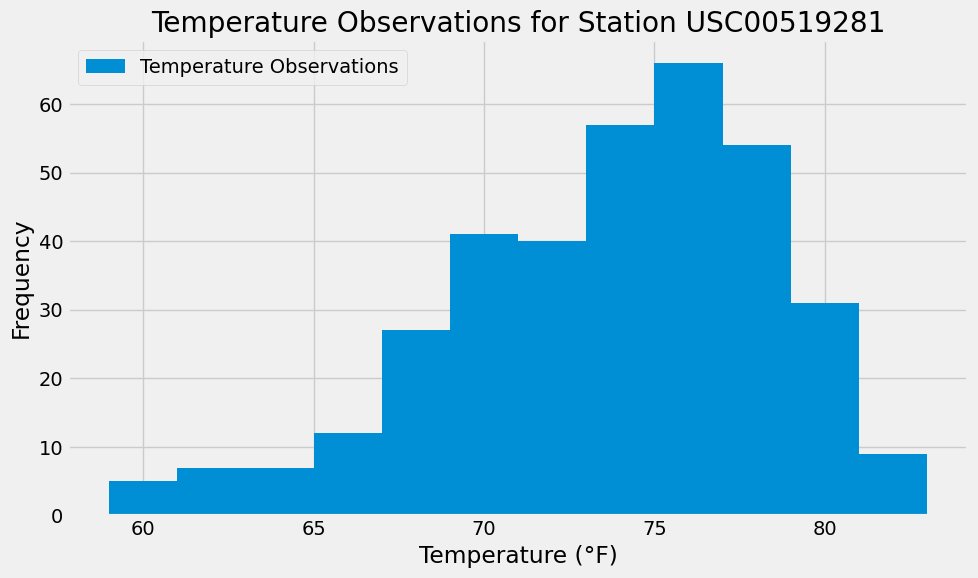

In [61]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query to find the most active station
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

# Extract the most active station ID
most_active_station_id = most_active_station[0]

# Calculate the date one year ago from the most recent date
most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).scalar()
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_date - timedelta(days=365)

# Query to retrieve the temperature observation data for the last 12 months
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_temperature = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(df_temperature['Temperature'], bins=12, label='Temperature Observations')
plt.title(f'Temperature Observations for Station {most_active_station_id}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


# Close Session

In [62]:
# Close Session
session.close()